# Intro to Uber Movement Data

**Authors:** Alex Michels and Jinwoo Park

This notebook provides a brief overview of Uber Movement Data, demonstrates how to obtain and work with it, and illustrates a few examples of how to utilize the data for geospatial analysis.

In [1]:
# a few parameters/variables
FIGSIZE=(18, 12)

In [2]:
# import a few useful python packages
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import osmnx as ox

# Table of Contents

* [Overview](#overview)
* [Obtaining Uber Movement Data](#obtain)
    * [Web Interface](#obtain-web)
    * [Command Line Interface (CLI)](#obtain-cli)
* [Obtaining OpenStreetMap Data](#osm)
* [Using Uber Movement Data](#using)
* [Learn More / References](#ref)

<hr id="overview" />

# Overview

[Uber Movement](https://movement.uber.com/) provides access to aggregated data on travel-times, speeds, and mobility heatmaps which have been generously made available by Uber. This data is very valuable to researchers because travel-time data can be very costly to acquire. First, let's break down the three main types of data available:

* **Travel-Times:** This measures average travel-time (by day and time of day) between "traffic analysis zones" or neighborhoods, depending on the city. [Click here for an example in London](https://movement.uber.com/explore/london/travel-times).
* **Speeds:** This measures the speed as a percentage of free-flow travel-time on each segment of the road. [Click here for an example in New York City](https://movement.uber.com/explore/new_york/speeds).
* **Mobility Heatmap:** This is a newer feature showing traffic density within a city. [Click here for an example in Madrid](https://movement.uber.com/explore/madrid/mobility-heatmap).



<hr id="obtain" />

# Obtaining Uber Movement Data

While the web interface is beautiful, we need to obtain the data and combine it with other data for many of our analysis and modeling use-cases. There are two main ways to obtain the data: through the web interface and using the CLI created by Uber.

<p id="obtain-web" />

## Web Interface

The web interface provides a convenient and easy way to obtain data. 

First, let's visit the Uber Movement page in another tab: https://movement.uber.com/

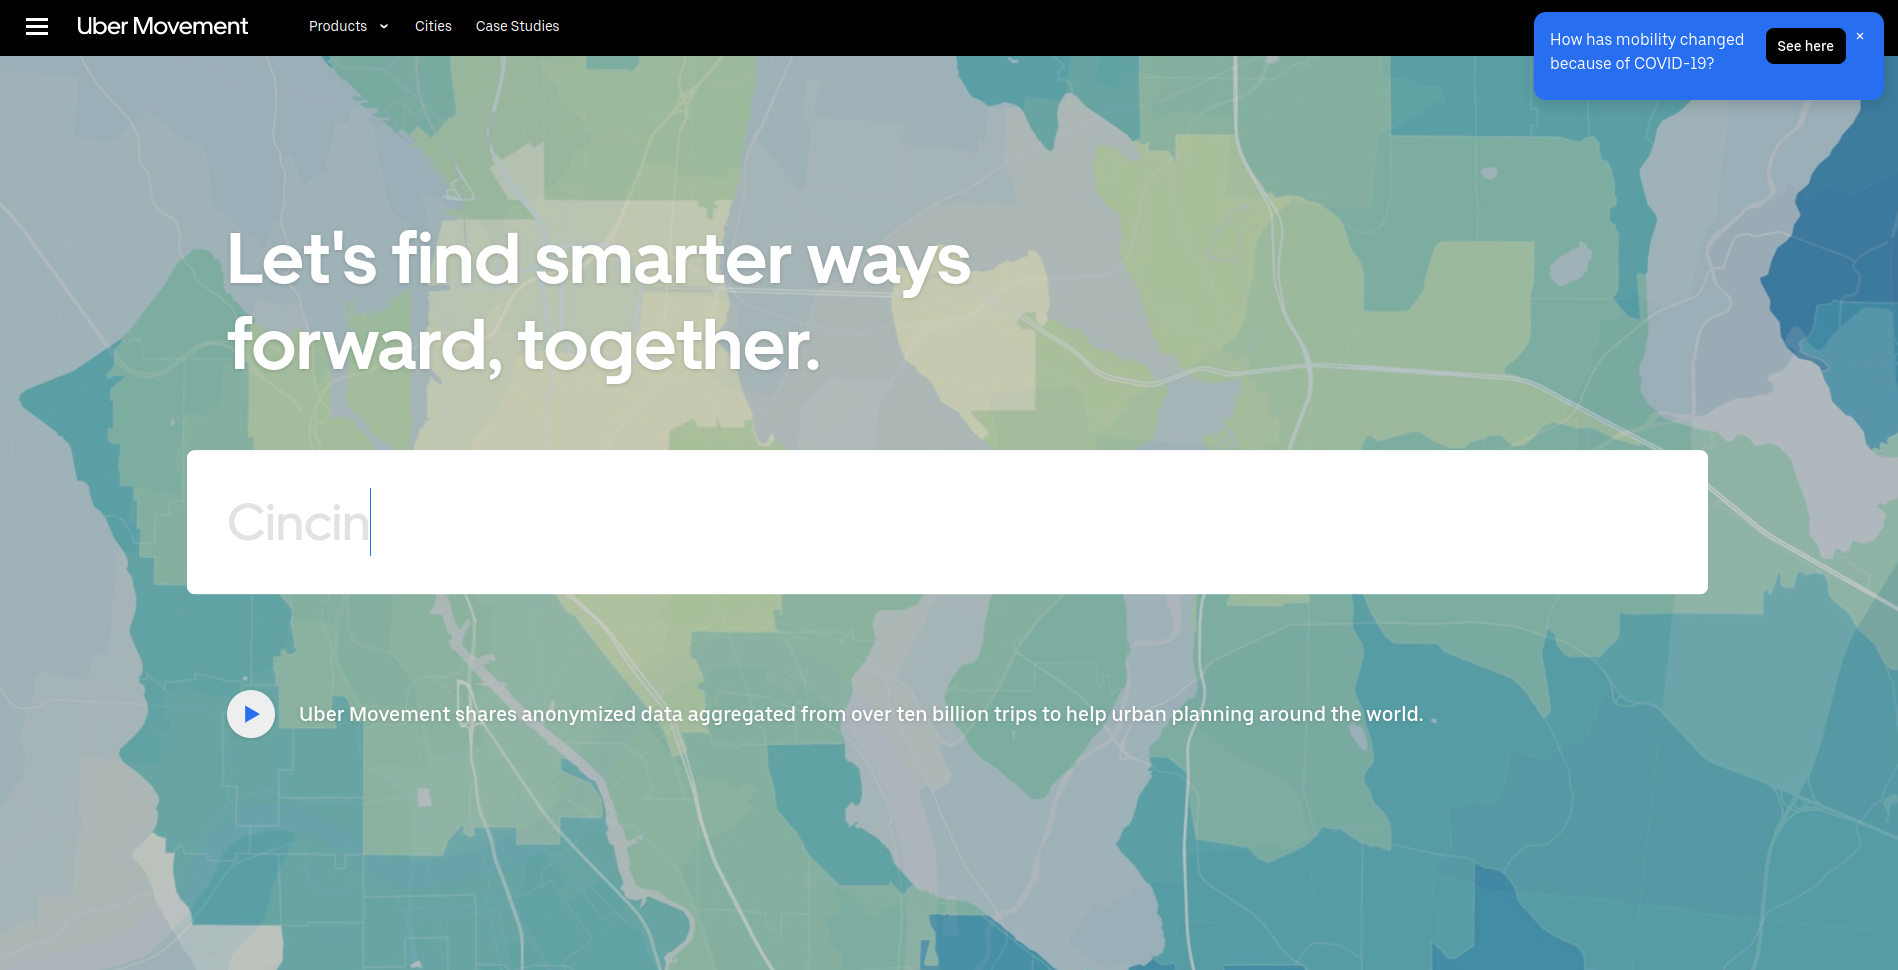

Mouse over "Products" in the top-left corner to view the three types of data products. Let's first select "Travel Times." You should see a screen like this:

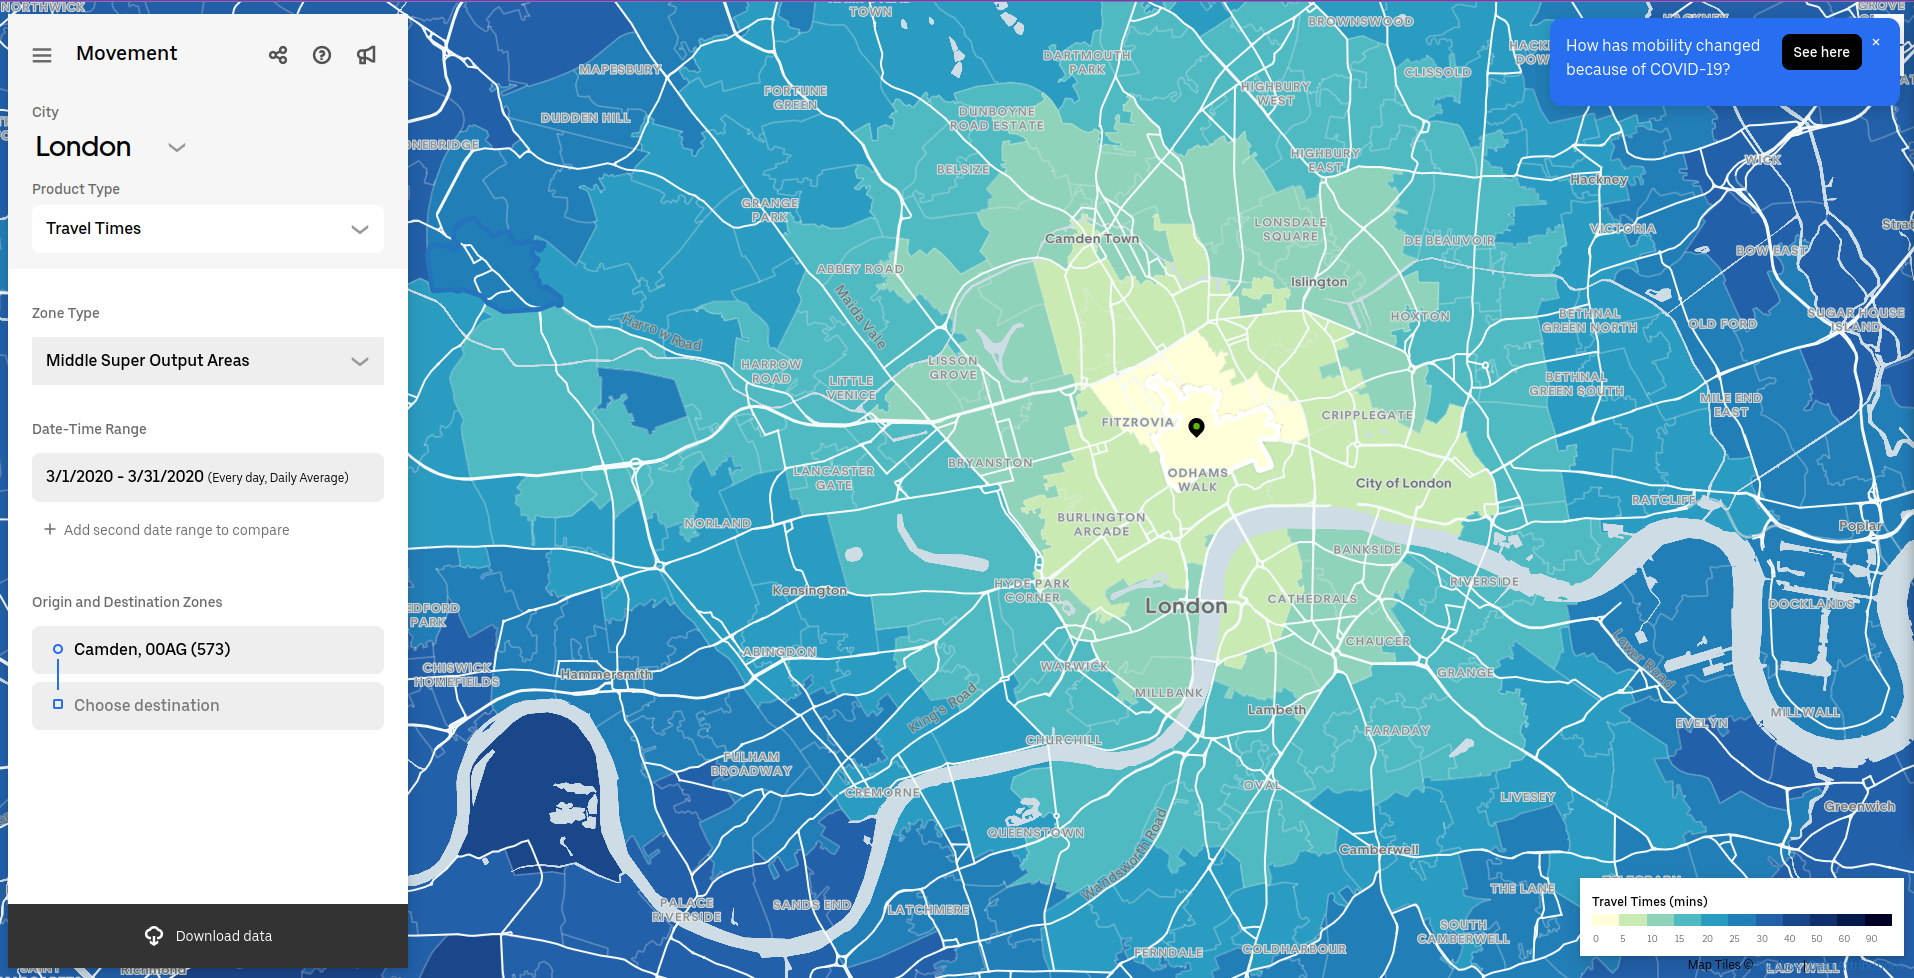

The menu on the left allows you to alterthe data by selecting date ranges, origins, and destinations. We can download the data using the "Download Data" button in the bottom-left.

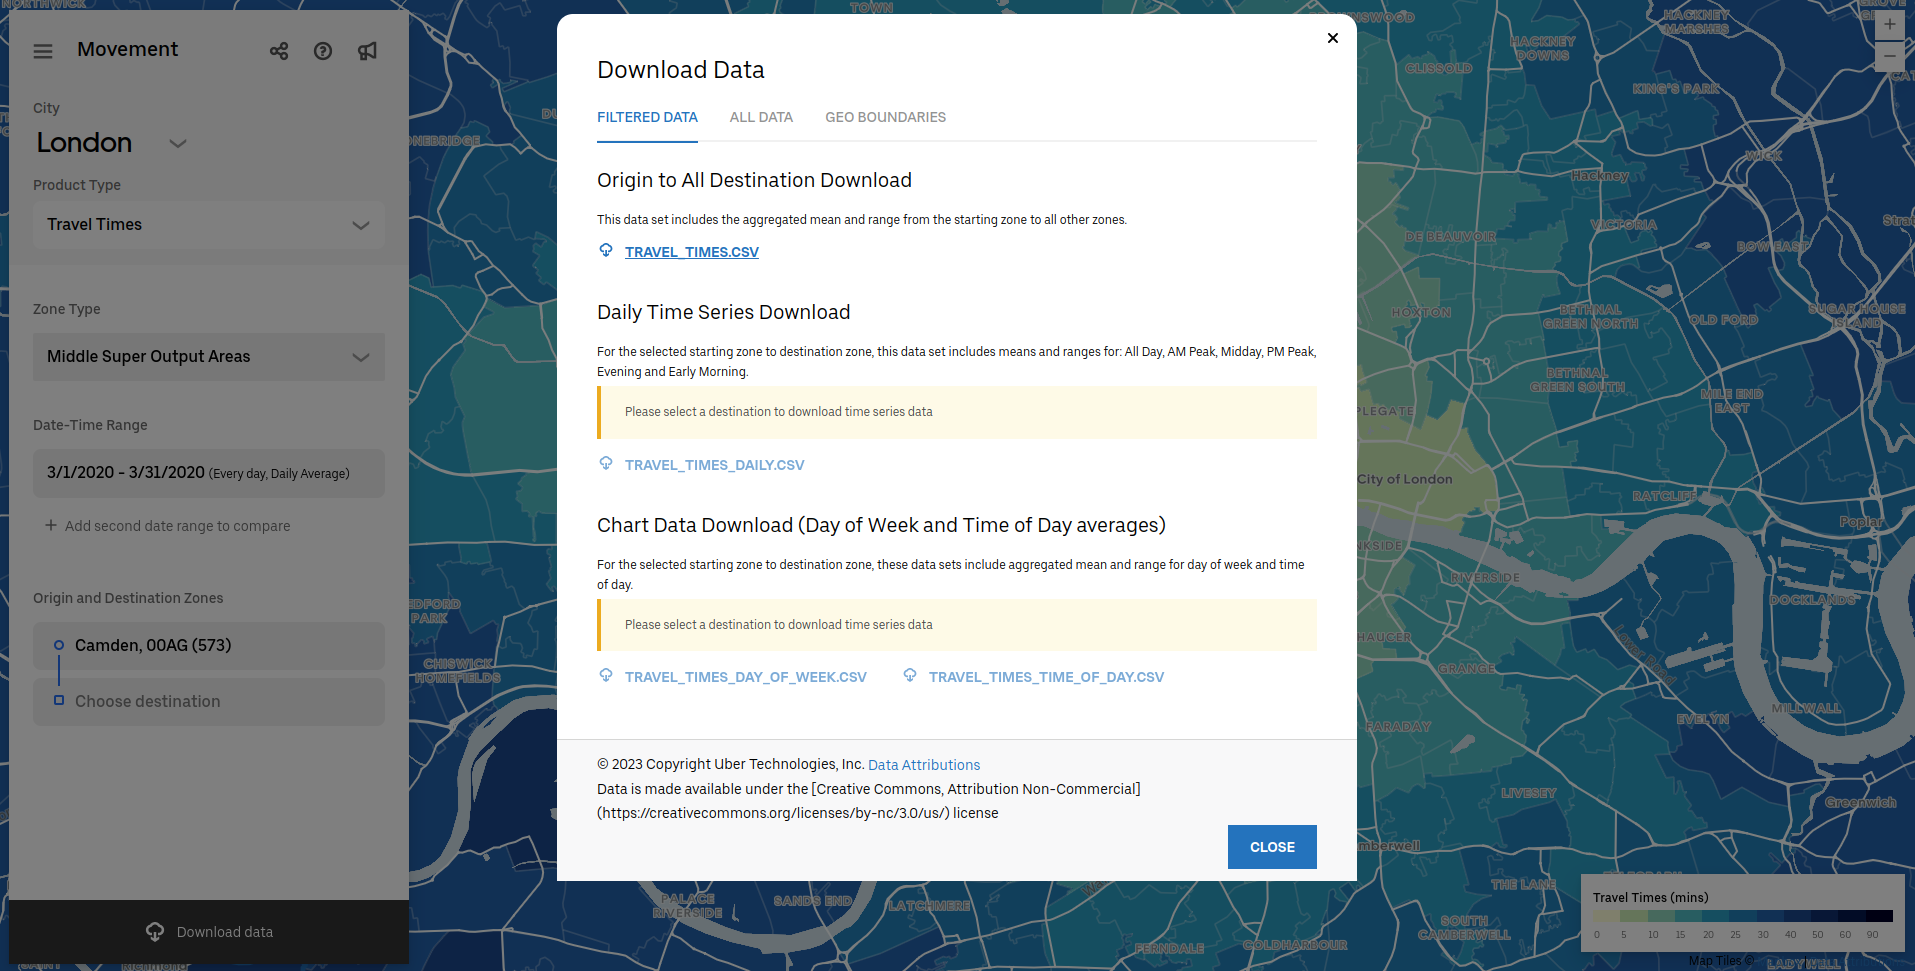

The Download Data screen provides a variety of options for filtered data, all data, and geo boundaries.

<p id="obtain-cli" />

## Command Line Interface (CLI)

The web interface is convenient for exploring and downloading data, but there is also a Commander Line Interface (CLI) available to use called [movement-data-toolkit](https://www.npmjs.com/package/movement-data-toolkit). 

Let's install the CLI:

In [3]:
!npm install -g movement-data-toolkit

npm WARN deprecated @oclif/screen@1.0.4: Deprecated in favor of @oclif/corem
npm WARN deprecated cli-ux@5.6.7: Package no longer supported. Contact Support at https://www.npmjs.com/support for more info.
npm WARN deprecated axios@0.18.1: Critical security vulnerability fixed in v0.21.1. For more information, see https://github.com/axios/axios/pull/3410
m##################⸩ ⠋ reify:lodash: timing reifyNode:node_modules/movement-dat-da
changed 182 packages, and audited 183 packages in 14s

20 packages are looking for funding
  run `npm fund` for details

2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [4]:
# Let's check that the CLI installed:
# You should see the help text for the CLI print out.
!mdt --help

Tools and utilities for working with Uber Movement data

VERSION
  movement-data-toolkit/1.3.0 linux-x64 node-v17.1.0

USAGE
  $ mdt [COMMAND]

COMMANDS
  clear-cache           Some commands in this toolkit download files to a
                        temporary directory. These files can be rather large,
                        and it can be helpful to clear this data to reclaim disk
                        space.
  create-geometry-file  Creates a geojson file that contains the geometries for
                        each road segment in the specified city, as well as both
                        the corresponding OSM identifiers for each road segment.
  help                  display help for mdt
  speeds-to-geojson     Downloads and processes Movement speeds data into a
                        geojson file that can be visualized with Kepler.gl or
                        other geospatial visualization tools.
  speeds-transform      Downloads and transforms Movement Speeds data, filtering

Using this CLI, let's download the geometry for New York in 2020:

In [5]:
!mdt create-geometry-file new_york 2020 > data/newyork2020.geojson


create-geometry-file
Creates a geojson file that contains the geometries for each road segment in the specified city, as well as both the corresponding OSM identifiers for each road segment.
    
The produced file can help avoid the need to download and manipulate OSM geometries from the web yourself.
Data from OpenStreetMap–including road geometries or other OSM metadata and identifiers–is licensed under the Open Data Commons Open Database License (ODbL) by the OpenStreetMap Foundation (OSMF) (https://www.openstreetmap.org/copyright)


🗺  Road Geometries
    Reading geometries from input file...
🏗  Building output geojson...
🏗  Building output geojson... done
✅ Writing output...
✅ Writing output... done


Now, we can use the Geopandas package to load the file and plot it:

In [6]:
df = gpd.read_file("data/newyork2020.geojson")
df.head()

osmname  osmstartnodeid      osmhighway  osmendnodeid   osmwayid  \
0  147th Avenue        42856931        tertiary    5924962521  455778913   
1  147th Avenue      5924962521        tertiary      42856931  455778913   
2          None      3838008669  secondary_link    5212739096  380471663   
3          None      5212739096  secondary_link    3838008669  380471663   
4          None      5487813168  secondary_link    5212739096  604880067   

                                            geometry  
0  LINESTRING (-73.749 40.658, -73.748 40.658, -7...  
1  LINESTRING (-73.747 40.658, -73.747 40.658, -7...  
2        LINESTRING (-73.947 40.764, -73.947 40.764)  
3        LINESTRING (-73.947 40.764, -73.947 40.764)  
4        LINESTRING (-73.947 40.764, -73.947 40.764)

<AxesSubplot:>

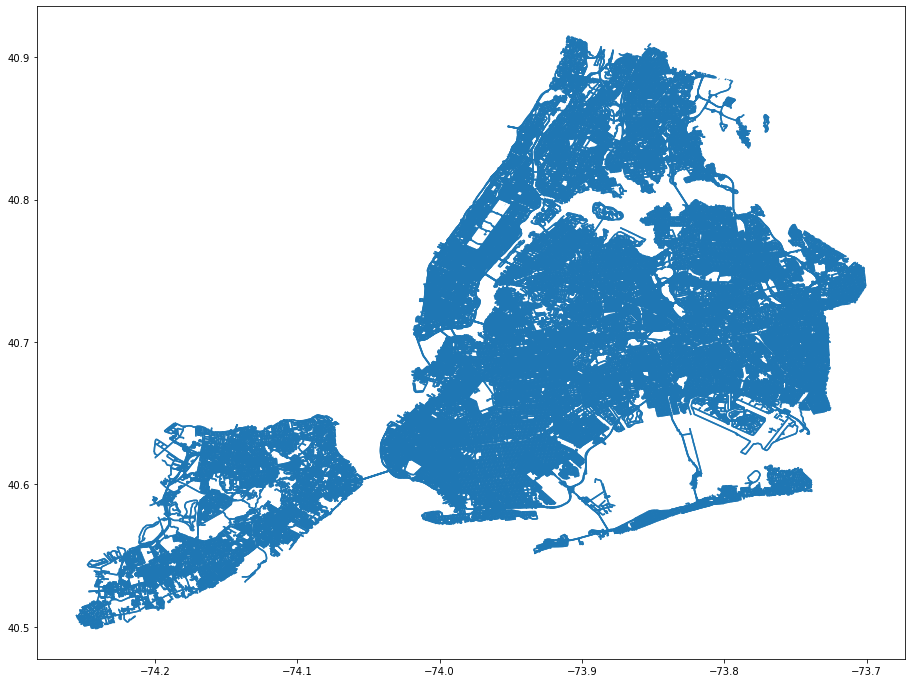

In [7]:
# This is a rather large file and will take a minute or so to plot
df.plot(figsize=FIGSIZE)

This is great, but the geometry of the road network can be obtained elsewhere. What we really want is the speed and travel time data. The MDT CLI can also be used to get the speed data over a given date range. 

The command below download the speeds in GeoJSON form New York city from November 1st, 2019 to November 2nd, 2019. 

**Note** that it takes >10 minutes to run, so we have provided the data already and the command is commented out, but you're welcome to run the command if you're willing to wait.

If you do run the command, you can [click here to skip over the very long output](#skip-mdt-download).

In [8]:
#!mdt speeds-to-geojson new_york 2019-11-01 2019-11-02 > data/nyspeed.geojson

<p id="skip-mdt-download" />

With our data downloaded, we can load and inspect it:

In [9]:
speed = gpd.read_file("data/nyspeed.geojson")
speed = speed.set_crs("EPSG:4326", allow_override=True)  # the CRS appears to be wrong if we don't manually set it
speed.head()

osmname  osmstartnodeid      osmhighway  osmendnodeid   osmwayid  \
0  147th Avenue        42856931        tertiary    5924962521  455778913   
1  147th Avenue      5924962521        tertiary      42856931  455778913   
2          None      3838008669  secondary_link    5212739096  380471663   
3          None      5212739096  secondary_link    3838008669  380471663   
4          None      5487813168  secondary_link    5212739096  604880067   

   speed_mean_mph  pct_from_freeflow  speed_freeflow_mph  \
0            22.0              -15.0                26.0   
1            22.0              -13.0                25.0   
2            19.0              -11.0                21.0   
3            15.0              -14.0                18.0   
4            14.0              -20.0                17.0   

                                            geometry  
0  LINESTRING (-73.74903 40.65762, -73.74849 40.6...  
1  LINESTRING (-73.74712 40.65751, -73.74729 40.6...  
2  LINESTRING (-73.94747 40.76396, -73.94744 40.7...  
3  LINESTRING (-73.94747 40.76402, -73.94750 40.7...  
4  LINESTRING (-73.94748 40.76408, -73.94747 40.7...

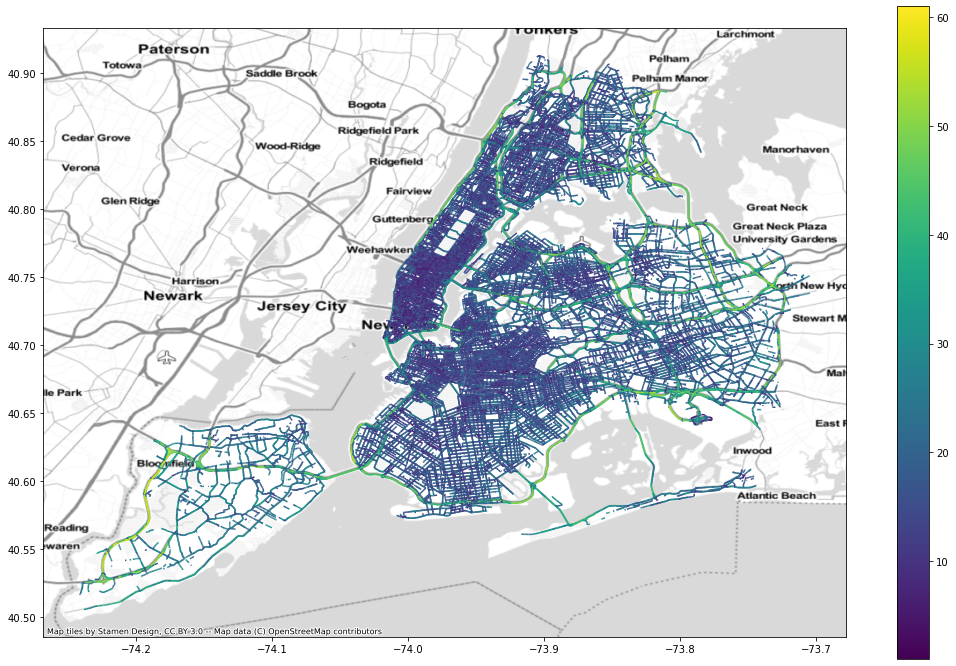

In [10]:
ax = speed.plot(column="speed_mean_mph", figsize=FIGSIZE, legend=True)
cx.add_basemap(ax, crs=speed.crs.to_string(), source=cx.providers.Stamen.TonerLite)

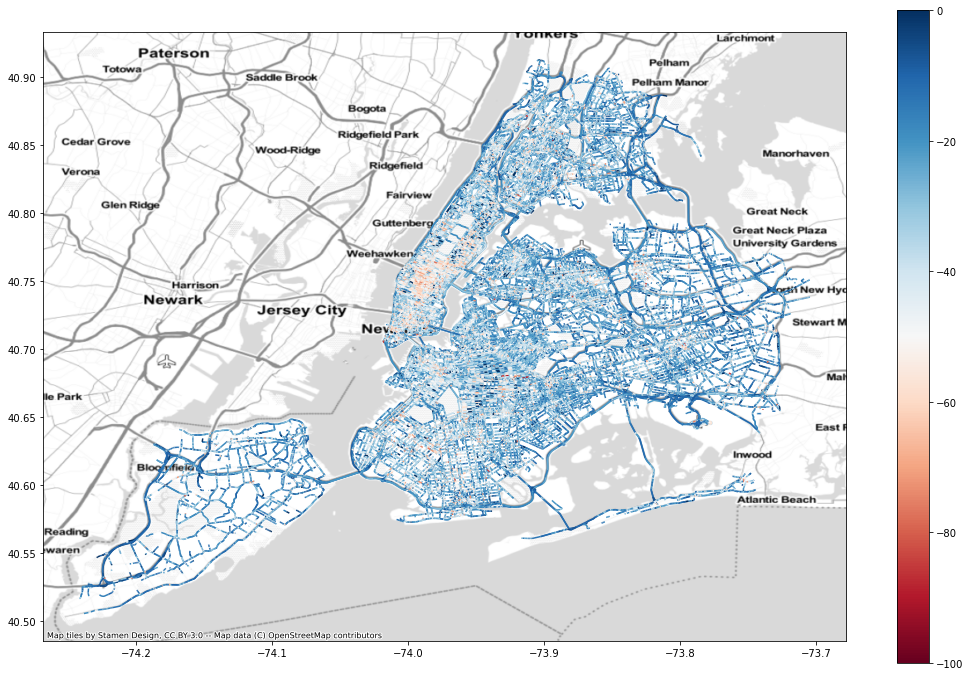

In [11]:
ax = speed.plot(column="pct_from_freeflow", figsize=FIGSIZE, cmap="RdBu", vmin=-100, vmax=0, legend=True)
cx.add_basemap(ax, crs=speed.crs.to_string(), source=cx.providers.Stamen.TonerLite)
plt.savefig("img/nyc-pct_from_freeflow.png")
plt.show()

We can theoretically create a networkx graph with the geoJSON that Uber Movements gives us, but we have run into issues in the past utilizing this graph for routing and network analysis. We have found that the better approach is to obtain our own road network from OpenStreetMap and attach the attributes we can to it.

In [12]:
# first, project to a non-geographic CRS like NAD83 for New York: https://epsg.io/32118
speed = speed.to_crs("EPSG:32118")
# then momepy can convert the geodataframe into a networkx graph
speednx = momepy.gdf_to_nx(speed)

In [13]:
type(speednx)

networkx.classes.multigraph.MultiGraph

<hr id="osm" />

# Obtaining OpenStreetMap Data

While the Uber data is extremely useful, we also need OpenStreetMap network data (which the Uber data is based on) in network form to perform routing and network analysis. [Check out our notebook if you'd like to learn more about OpenStreetmap Network data and `osmnx`](https://cybergisxhub.cigi.illinois.edu/notebook/introduction-to-openstreetmap-osm-network-data/).

Let's obtain the driving network for NYC:

In [14]:
# This code can be used to download the driving network for NYC from OpenStreetMap
# nyc = ox.graph_from_place("New York City, NY, USA", network_type='drive', simplify=False)

In [15]:
# Once the data is downloaded from OSM and in the "nyc" object, you can save it as a graphml (or other format)
# ox.save_graphml(nyc, filepath="data/nyc_osm_2023-05-31.graphml")

In [16]:
# zip the data because it's too large for Github
# !zip data/nyc_osm_2023-05-31.graphml.zip data/nyc_osm_2023-05-31.graphml

In [20]:
# unzip the data because its too large for Github uncompressed
!unzip data/nyc_osm_2023-05-31.graphml.zip

Archive:  data/nyc_osm_2023-05-31.graphml.zip
  inflating: data/nyc_osm_2023-05-31.graphml  


In [21]:
nyc = ox.load_graphml("data/nyc_osm_2023-05-31.graphml")

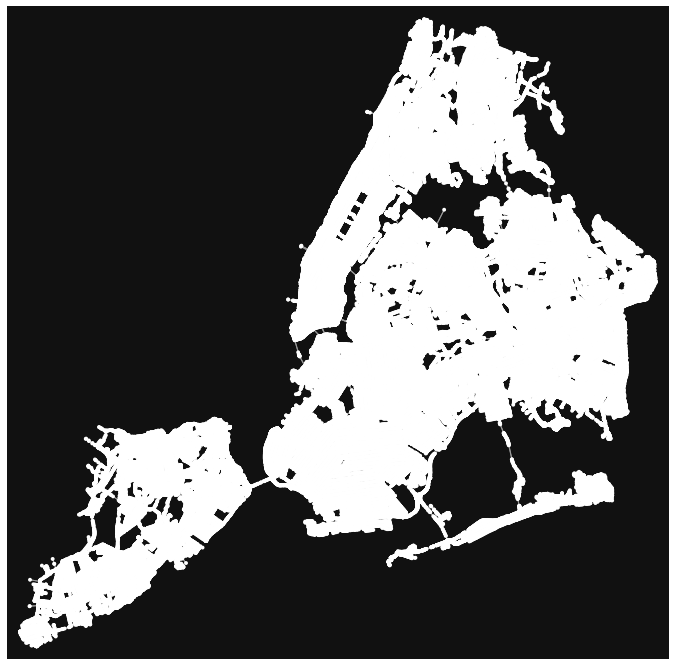

(<Figure size 1296x864 with 1 Axes>, <AxesSubplot:>)

In [22]:
ox.plot_graph(nyc, figsize=FIGSIZE)

<hr id="using" />

# Using Uber Movement Data

Calculate route using free-flow vs. with Uber data.

<hr id="ref" />

# Learn More / References

## Blogs and Informal Resources

* ["Working with Uber Movement Speeds data" by David Schnurr on Medium](https://medium.com/uber-movement/working-with-uber-movement-speeds-data-cc01d35937b3)


## Academic Papers